# **Processamento de Linguagem Natural [2022.Q2]**
Prof. Alexandre Donizeti Alves

### *Classificação e Recomendação de Notícias*

Neste notebook faremos a classificação de notícias em cinco categorias distintas e sugeriremos as notícias com o maior grau de relação:

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk



Link da base utilizada:
https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive

In [2]:
df_bbc = pd.read_csv(r".\Bases\bbc-news-data.csv",sep='\t')
df_bbc

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


Primeiramente vamos entender quantas categorias nosso dataset possui

In [3]:
df_bbc['category'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Agora utilizaremos uma função do sklearn para fazer o encoding

In [4]:
le = LabelEncoder()
df_bbc['category_int'] = le.fit_transform(df_bbc['category'])

In [5]:
le.inverse_transform([0,1,2,3,4])

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

'business' = 0, 'entertainment'= 1, 'politics'= 2, 'sport'= 3, 'tech'= 4

### *Sumarização*


Vamos criar um método que separa um texto em sentenças. Cada sentença é então dividida em tokens, e usamos um *POS-Tagger* e um Reconhecedor de Entidades Nomeadas para encontrar substantivos e entidades nomeadas (a lista de entidades nomeadas reconhecidas é dado pela base '`words`' do `nltk`. A seguir, o método calcula a porcentagem de tokens que são nomes ou entidades nomeadas, e gera um ranking baseado nessa porcentagem. O método retorna uma lista de sentenças, ordenadas por essa pontuação (*score*).

In [6]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Utilizaremos a função abaixo para realizar a sumarização de todos os textos

In [7]:
def summary(content):
    ranking = []
    
    # quebra o documento em sentencas
    for (i, sentence) in enumerate(nltk.sent_tokenize(content)):
        
        # quebra a sentenca em palavras
        tokens         = nltk.wordpunct_tokenize(sentence)
        tokens = [token for token in tokens if token.isalpha()]
        
        # faz o pos-tagging
        tagged         = nltk.pos_tag(tokens)
        
        # encontra as entidades nomeadas
        named_entities = nltk.ne_chunk(tagged, binary=True)
        nTokens        = len(tokens)

        #print (f"\n{i} : >>{sentence}<<\n")

        # contagem dos substantivos: NN e NNP
        nNouns = 0
        for (word, pos) in tagged:
            if pos in ["NN", "NNP"]:
                nNouns += 1
                #print (word, pos)

        # contagem de entidades nomeadas
        nNes = 0
        for ne in named_entities:
            if hasattr(ne, 'label') and ne.label() == "NE":
                nNes += 1
                #print (ne)

        # calculo do score ingenuo
        # soma dos nomes e entidades nomeadas
        try:
            score = (nNes + nNouns)/float(nTokens)
        except:
            score = 0
        ranking.append( {'id':i, 'score':score, 'nNes':nNes, 'nNouns':nNouns, 'nTokens':nTokens, 'sentence':sentence} )
    
    # retorna as sentencas, ordenadas pelo ranking
    return(sorted( ranking, key=lambda x: x['score'], reverse=True))

In [8]:
df_bbc['content_sumarizado'] = ''

In [9]:
for a in range(len(df_bbc['content'])):
    sents = summary(df_bbc['content'][a])
    df_bbc['content_sumarizado'][a] = sents[0]['sentence']

<ipython-input-9-6006842a9224>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbc['content_sumarizado'][a] = sents[0]['sentence']


Podemos ver abaixo a sumarização de um artigo na prática

In [10]:
df_bbc['content_sumarizado'][0]

'Time Warner said on Friday that it now owns 8% of search-engine Google.'

In [11]:
df_bbc['content'][0]

' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for high-

Por uma questão de precisão para a Classificação utilizaremos o título e o texto tratado após sumarização

In [12]:
df_bbc['content_sum'] = df_bbc['title'] + ' ' + df_bbc['content_sumarizado']

Inicialmente, vamos fazer uma contagem de documentos em cada classe:

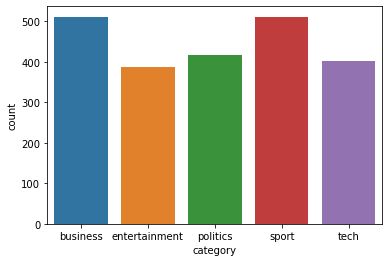

In [13]:
# biblioteca para fazer graficos
import seaborn as sns

# contagem de textos em cada classe
sns.countplot(x="category",data=df_bbc);

In [14]:
df_bbc['len'] = df_bbc['content_sum'].str.len()

df_bbc['len'][:5]


0    105
1    230
2    165
3    143
4    136
Name: len, dtype: int64

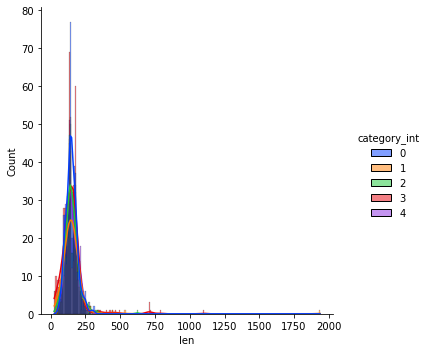

In [15]:
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.displot(data=df_bbc, x="len", hue="category_int", kind="hist", kde=True,palette=sns.color_palette('bright', 5))

### *Pré-Processamento*



In [16]:
import nltk

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# tokenizador
# ao inves de criar uma expressão regular explicita, vamos usar o wordpunct_tokenize
# ele define uma expressão regular para quebrar strings em substrings, repeitando a pontuacao
# a biblioteca NLTK disponibliza outros tokenizadores

from nltk.tokenize import wordpunct_tokenize

# lista de stopwords 
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# stemmer
from nltk.stem.porter import PorterStemmer
stm = PorterStemmer()

# lematizador
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

# pontuacao
import string

def preproc_tokenizer(text, reduc='stemmer'):
    
    # quebra o documento em  tokens
    words = wordpunct_tokenize(text) 
    
    # converte palavras para minusculo
    words = [word.lower() for word in words]
    
    # remove as stopwords
    words = [word for word in words if word not in stopwords]
    
    # remove pontuacao
    words = [word for word in words if word not in string.punctuation]
    
    if reduc == 'lemmatizer':
        words = [wnl.lemmatize(word) for word in words] 
    else:
        words = [stm.stem(word) for word in words]

    return(words)

In [18]:
df_bbc['stems'] = [preproc_tokenizer(text,reduc='stemmer') for text in df_bbc['content_sum']]
df_bbc.head(5)

,category,filename,title,content,category_int,content_sumarizado,content_sum,len,stems
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,0,Time Warner said on Friday that it now owns 8%...,Ad sales boost Time Warner profit Time Warner ...,105,"[ad, sale, boost, time, warner, profit, time, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,0,"""I think the chairman's taking a much more san...","Dollar gains on Greenspan speech ""I think the ...",230,"[dollar, gain, greenspan, speech, think, chair..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,0,State-owned Rosneft bought the Yugansk unit fo...,Yukos unit buyer faces loan claim State-owned ...,165,"[yuko, unit, buyer, face, loan, claim, state, ..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,0,Aviation analyst Nick Van den Brul of BNP Pari...,High fuel prices hit BA's profits Aviation ana...,143,"[high, fuel, price, hit, ba, profit, aviat, an..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,0,Pernod is home to brands including Chivas Rega...,Pernod takeover talk lifts Domecq Pernod is ho...,136,"[pernod, takeov, talk, lift, domecq, pernod, h..."


In [19]:
df_bbc['lemmas'] = [preproc_tokenizer(text,reduc='lemmatizer') for text in df_bbc['content_sum']]
df_bbc.head()

,category,filename,title,content,category_int,content_sumarizado,content_sum,len,stems,lemmas
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,0,Time Warner said on Friday that it now owns 8%...,Ad sales boost Time Warner profit Time Warner ...,105,"[ad, sale, boost, time, warner, profit, time, ...","[ad, sale, boost, time, warner, profit, time, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,0,"""I think the chairman's taking a much more san...","Dollar gains on Greenspan speech ""I think the ...",230,"[dollar, gain, greenspan, speech, think, chair...","[dollar, gain, greenspan, speech, think, chair..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,0,State-owned Rosneft bought the Yugansk unit fo...,Yukos unit buyer faces loan claim State-owned ...,165,"[yuko, unit, buyer, face, loan, claim, state, ...","[yukos, unit, buyer, face, loan, claim, state,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,0,Aviation analyst Nick Van den Brul of BNP Pari...,High fuel prices hit BA's profits Aviation ana...,143,"[high, fuel, price, hit, ba, profit, aviat, an...","[high, fuel, price, hit, ba, profit, aviation,..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,0,Pernod is home to brands including Chivas Rega...,Pernod takeover talk lifts Domecq Pernod is ho...,136,"[pernod, takeov, talk, lift, domecq, pernod, h...","[pernod, takeover, talk, lift, domecq, pernod,..."


In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

def gen_wordcloud(texts, title, size=50):
    # conta a frequencia de cada termo 
    frequencies = Counter(token for doc in texts for token in set(doc))
    
    # gera a nuvem de palavras
    wc = WordCloud()
    wc.generate_from_frequencies(dict(frequencies.most_common(size)))
    
    # plota a nuvem
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

A nuvem de palavras pode então ser gerada a partir dos *stems*:

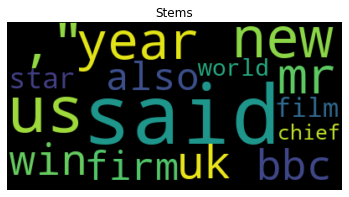

In [21]:
gen_wordcloud(df_bbc['stems'],"Stems", 15)

Podem gerar também a partir dos *lemmas*:

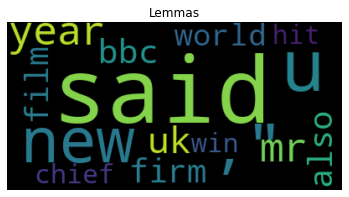

In [22]:
gen_wordcloud(df_bbc['lemmas'],"Lemmas", 15)

Podemos também gerar nuvens de palavras separadas por classe:

'business' = 0, 'entertainment'= 1, 'politics'= 2, 'sport'= 3, 'tech'= 4

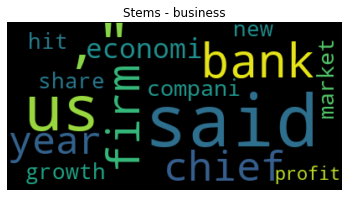

In [23]:
gen_wordcloud(df_bbc['stems'][df_bbc['category_int'].astype(str).str.match('0')],"Stems - business", 15)

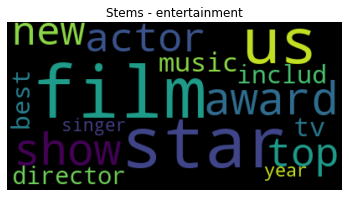

In [24]:
gen_wordcloud(df_bbc['stems'][df_bbc['category_int'].astype(str).str.match('1')],"Stems - entertainment", 15)

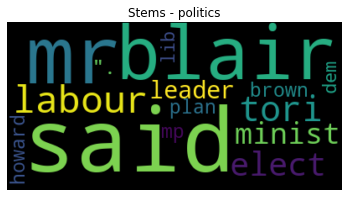

In [25]:
gen_wordcloud(df_bbc['stems'][df_bbc['category_int'].astype(str).str.match('2')],"Stems - politics", 15)

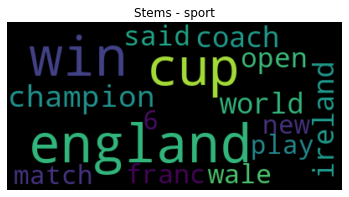

In [26]:
gen_wordcloud(df_bbc['stems'][df_bbc['category_int'].astype(str).str.match('3')],"Stems - sport", 15)

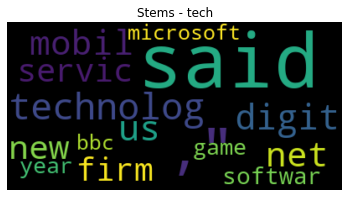

In [27]:
gen_wordcloud(df_bbc['stems'][df_bbc['category_int'].astype(str).str.match('4')],"Stems - tech", 15)

Também para lemmas

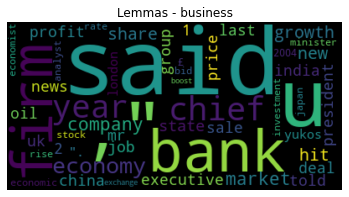

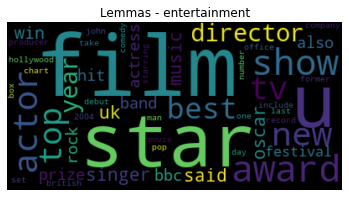

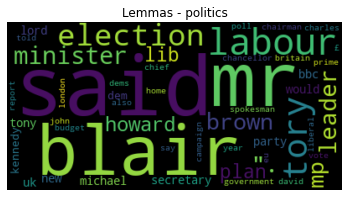

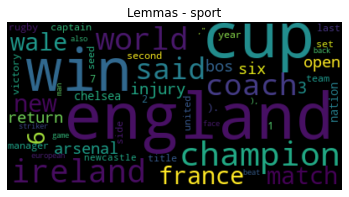

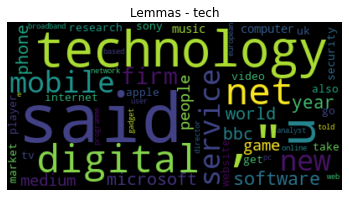

In [28]:
gen_wordcloud(df_bbc['lemmas'][df_bbc['category_int'].astype(str).str.match('0')],"Lemmas - business")
gen_wordcloud(df_bbc['lemmas'][df_bbc['category_int'].astype(str).str.match('1')],"Lemmas - entertainment")
gen_wordcloud(df_bbc['lemmas'][df_bbc['category_int'].astype(str).str.match('2')],"Lemmas - politics")
gen_wordcloud(df_bbc['lemmas'][df_bbc['category_int'].astype(str).str.match('3')],"Lemmas - sport")
gen_wordcloud(df_bbc['lemmas'][df_bbc['category_int'].astype(str).str.match('4')],"Lemmas - tech")

### **Avaliação do Modelo de Classificação**

Aqui utilizaremos três modelos distintos para realizar a classificação e compará-los

In [29]:
# metodo que faz a divisao do conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split

# separa o corpus original em dois corpus (treino e teste), deixando 30% no de teste
# como eh um processso aleatorio, fixei a semente para que o experimento seja reprodutivel
df_bbc_train, df_bbc_test =  train_test_split(df_bbc, test_size=0.3, random_state=0)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

train_stems = vectorizer.fit_transform([" ".join(doc) for doc in df_bbc_train['stems']])
test_stems = vectorizer.transform([" ".join(doc) for doc in df_bbc_test['stems']])

train_lemmas = vectorizer.fit_transform([" ".join(doc) for doc in df_bbc_train['lemmas']])
test_lemmas = vectorizer.transform([" ".join(doc) for doc in df_bbc_test['lemmas']])

Uma vez criada a matriz termo-documento, podemos criar os modelos de classificação. Nesse experimento, vamos comparar três algoritmos diferentes:

- [SVM](https://pt.wikipedia.org/wiki/M%C3%A1quina_de_vetores_de_suporte) As máquinas de vetores de suporte (SVM, do inglês: *Support Vector Machine*) contempla uma família de algoritmos de aprendizado de máquina que busca encontrar uma hiperplano que separa as classes no espaço vetorial de maneira a a maximizar a distância entre os pontos mais próximos em relação a cada uma das classes.

- [Regressão Logística](https://pt.wikipedia.org/wiki/Regress%C3%A3o_log%C3%ADstica) A regressão logística é um modelo que tenta atribuir probabilidades a diferentes categorias. Ela assume que as classes podem ser modeladas como uma distribuição multivariada, e usa a distância ao centro da distribuição de cada uma das classes para calcular a verossimilhança entre as classes. Para transformar em probabilidades, essa verossimilhante é transformada em probabilidades usando a função logística.

- [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) O Naive Bayes é baseado no teorema de Bayes para classificar os documentos. O teorema é usado para calcular a probalidade da classe, dado o valor dos atributos, a partir da probabilidade de cada atributo, dada a classe. O algoritmo é chamado *naive* (ingênuo), pois não considera a probabilidade conjunta entre as classes. 

Para comparar os algoritmos, vamos usar porcentagem de acertos (**acurácia**). Essa métrica compara a predição para o conjunto de teste com o valor real da classe e calcula a porcentagem de acertos. Como a base é balanceada, essa métrica é um bom indicador da qualidade do modelo, mas se tivermos uma desproporção entre as classes, outras métricas podem ser usadas.

In [31]:
# carrega os algoritmos
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# métrica de avaliação
from sklearn.metrics import accuracy_score
# calcular a acuracia da classe de predicao
from sklearn import metrics

# cria objetos para aplicar os algoritmos. 
# Usamos um dicionário com o nome, objeto para facilitar a visualização dos resultados
algoritms = {'SVM' : LinearSVC(),'Regressão Logística' : LogisticRegression(), 'Naive Bayes': GaussianNB()}

In [32]:
train_stems

<1557x6528 sparse matrix of type '<class 'numpy.float64'>'
	with 25240 stored elements in Compressed Sparse Row format>

In [33]:
train_lemmas

<1557x7458 sparse matrix of type '<class 'numpy.float64'>'
	with 25180 stored elements in Compressed Sparse Row format>

Abaixo o desempenho dos modelos de Classificação para a base tratada com o Stemming junto à acurácia. 

Podemos observar que o SVM e Regressão Logística desempenharam de forma semelhante, obtendo cerca de 90% de precissão na categorização

In [34]:
# executa os algoritmos para a base pre-processada com o stemmer
for name, alg in algoritms.items():
    alg.fit(train_stems.toarray(),df_bbc_train['category_int'])
    predictions_stem = alg.predict(test_stems.toarray())
    print("\nAcurácia média com stemming e o algoritmo {0} {1:.2f}%".format(name, accuracy_score(df_bbc_test['category_int'],predictions_stem)*100))
    mtr = metrics.confusion_matrix(df_bbc_test['category_int'],predictions_stem)
    print(mtr)
    i=0
    categorias = {0: 'business', 1:'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    for a in mtr:
        b = [0,1,2,3,4]
        b.remove(i)
        print(mtr[i][i].astype(str) + " notícias foram classificadas como {0} categorias e eram {0}".format(categorias[i]))
        print(sum(mtr[i][b]).astype(str) + " notícias foram classificadas como {0} mas eram de outras categorias\n".format(categorias[i]))
        i=i+1


Acurácia média com stemming e o algoritmo SVM 90.87%
[[146   1   4   1   3]
 [  8  95   3   4   5]
 [  3   2 111   4   1]
 [  2   1   1 156   0]
 [  7   6   3   2  99]]
146 notícias foram classificadas como business categorias e eram business
9 notícias foram classificadas como business mas eram de outras categorias

95 notícias foram classificadas como entertainment categorias e eram entertainment
20 notícias foram classificadas como entertainment mas eram de outras categorias

111 notícias foram classificadas como politics categorias e eram politics
10 notícias foram classificadas como politics mas eram de outras categorias

156 notícias foram classificadas como sport categorias e eram sport
4 notícias foram classificadas como sport mas eram de outras categorias

99 notícias foram classificadas como tech categorias e eram tech
18 notícias foram classificadas como tech mas eram de outras categorias


Acurácia média com stemming e o algoritmo Regressão Logística 89.97%
[[147   2   2  

Com a Lemmatizaçãoos obtivemos uma melhor acurácia em comparação à base tratada com Stemming, assim como no primeiro modelo, os algoritmos SVM e Regressão Logística tiveram um desempenho consideravalmente melhor que Naive Bayes

In [35]:
# executa os algoritmos para a base pre-processada com o lemmatizador
for name, alg in algoritms.items():
    alg.fit(train_lemmas.toarray(),df_bbc_train['category_int'])
    predictions_lem = alg.predict(test_lemmas.toarray())
    print("\nAcurácia média com lematização e o algoritmo {0} {1:.2f}%".format(name, accuracy_score(df_bbc_test['category_int'],predictions_lem)*100))
    mtr = metrics.confusion_matrix(df_bbc_test['category_int'],predictions_lem)
    print(mtr)
    i=0
    categorias = {0: 'business', 1:'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    for a in mtr:
        b = [0,1,2,3,4]
        b.remove(i)
        print(mtr[i][i].astype(str) + " notícias foram classificadas como {0} categorias e eram {0}".format(categorias[i]))
        print(sum(mtr[i][b]).astype(str) + " notícias foram classificadas como {0} mas eram de outras categorias\n".format(categorias[i]))
        i=i+1


Acurácia média com lematização e o algoritmo SVM 92.07%
[[148   0   3   1   3]
 [  6  98   3   4   4]
 [  4   0 111   5   1]
 [  1   2   1 156   0]
 [  6   6   1   2 102]]
148 notícias foram classificadas como business categorias e eram business
7 notícias foram classificadas como business mas eram de outras categorias

98 notícias foram classificadas como entertainment categorias e eram entertainment
17 notícias foram classificadas como entertainment mas eram de outras categorias

111 notícias foram classificadas como politics categorias e eram politics
10 notícias foram classificadas como politics mas eram de outras categorias

156 notícias foram classificadas como sport categorias e eram sport
4 notícias foram classificadas como sport mas eram de outras categorias

102 notícias foram classificadas como tech categorias e eram tech
15 notícias foram classificadas como tech mas eram de outras categorias


Acurácia média com lematização e o algoritmo Regressão Logística 91.32%
[[147   

### *Recomendação de Notícias*


In [36]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
import re
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df_bbc['content_sum']))
len(norm_corpus)

2225

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = tf.fit_transform(norm_corpus)
tfidf_matrix.shape

(2225, 8987)

Usamos uni-grama e bi-gramas como nossas características e removemos termos que ocorrem em apenas um documento em todo o corpus. Agora que temos nossos documentos normalizados e vetorizados com representações vetoriais baseadas em TF-IDF, veremos como calcular a similaridade de documentos com a similaridade por cosseno.

**Similariade de documentos aos pares**

Vimos os conceitos relativos à computação de similaridade por cosseno e os implementamos para similaridade de termo. Aqui, reutilizamos os mesmos conceitos para calcular as pontuações de similaridade por cosseno para documentos em vez de termos. Os vetores de documentos serão o saco de vetores baseados em modelos de palavras com valores TF-IDF em vez de frequências de termos.

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

doc_sim = cosine_similarity(tfidf_matrix)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2215,2216,2217,2218,2219,2220,2221,2222,2223,2224
0,1.000000,0.082697,0.0,0.0,0.0,0.012395,0.007293,0.047005,0.000000,0.0,...,0.0,0.035558,0.013416,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.082697,1.000000,0.0,0.0,0.0,0.060309,0.005576,0.039074,0.000000,0.0,...,0.0,0.000000,0.010257,0.052282,0.021822,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.057073,0.051256,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Criaremos uma coluna de identificação única para cada notícia

In [40]:
df_bbc['id'] = df_bbc.index.tolist()

In [41]:
news_list = df_bbc['id'].values
news_list, news_list.shape

(array([   0,    1,    2, ..., 2222, 2223, 2224], dtype=int64), (2225,))

Vamos selecionar uma notícia aleatória para buscar suas semelhantes

In [42]:
news_idx = np.where(news_list == 1314)[0][0]
news_idx

1314

Agora usaremos este índice posicional para obter o vetor de semelhanças de notícias aos pares para todas notícias com a notícia 102

In [43]:
news_similarities = doc_sim_df.iloc[news_idx].values
news_similarities

array([0.       , 0.       , 0.0234979, ..., 0.       , 0.       ,
       0.       ])

In [44]:
similar_news_idxs = np.argsort(-news_similarities)[1:6]
similar_news_idxs

array([1319, 1602, 1613, 1666, 1350], dtype=int64)

Podemos obter facilmente cinco principais notícias semelhantes à qualquer notícia à nossa escolha, uma vez que já temos as posições de índice delas.

In [45]:
similar_news = news_list[similar_news_idxs]
similar_news

array([1319, 1602, 1613, 1666, 1350], dtype=int64)

In [46]:
df_bbc[df_bbc['id']==news_idx]

,category,filename,title,content,category_int,content_sumarizado,content_sum,len,stems,lemmas,id
1314,sport,002.txt,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would...,3,O'Sullivan will also take part in the Bupa Gre...,O'Sullivan could run in Worlds O'Sullivan will...,113,"[sullivan, could, run, world, sullivan, also, ...","[sullivan, could, run, world, sullivan, also, ...",1314


In [47]:
df_bbc[df_bbc['id'].isin(similar_news_idxs)]

,category,filename,title,content,category_int,content_sumarizado,content_sum,len,stems,lemmas,id
1319,sport,007.txt,O'Sullivan commits to Dublin race,Sonia O'Sullivan will seek to regain her titl...,3,Sonia O'Sullivan will seek to regain her titl...,O'Sullivan commits to Dublin race Sonia O'Sul...,133,"[sullivan, commit, dublin, race, sonia, sulliv...","[sullivan, commits, dublin, race, sonia, sulli...",1319
1350,sport,038.txt,Radcliffe proves doubters wrong,This won't go down as one of the greatest mar...,3,Now Paula will take part in the Run London 10k...,Radcliffe proves doubters wrong Now Paula will...,203,"[radcliff, prove, doubter, wrong, paula, take,...","[radcliffe, prof, doubter, wrong, paula, take,...",1350
1602,sport,290.txt,O'Gara revels in Ireland victory,Ireland fly-half Ronan O'Gara hailed his side...,3,O'Sullivan also rejected Robinson's contention...,O'Gara revels in Ireland victory O'Sullivan al...,115,"[gara, revel, ireland, victori, sullivan, also...","[gara, revel, ireland, victory, sullivan, also...",1602
1613,sport,301.txt,O'Sullivan quick to hail Italians,Ireland coach Eddie O'Sullivan heaped praise ...,3,Ireland coach Eddie O'Sullivan heaped praise ...,O'Sullivan quick to hail Italians Ireland coa...,146,"[sullivan, quick, hail, italian, ireland, coac...","[sullivan, quick, hail, italian, ireland, coac...",1613
1666,sport,354.txt,O'Sullivan keeps his powder dry,When you are gunning for glory and ultimate s...,3,Take the Triple Crown-winning side of 1985 und...,O'Sullivan keeps his powder dry Take the Tripl...,92,"[sullivan, keep, powder, dri, take, tripl, cro...","[sullivan, keep, powder, dry, take, triple, cr...",1666


Abaixo a porcentagem de semelhança entre a notícia escolhida e as que possuem maior grau de similaridade

In [48]:
doc_sim_df.loc[similar_news, news_idx]

1319    0.771595
1602    0.284410
1613    0.224243
1666    0.204285
1350    0.176843
Name: 1314, dtype: float64

In [49]:
list(df_bbc[df_bbc['id']==similar_news_idxs[0]]['content_sum'])

["O'Sullivan commits to Dublin race  Sonia O'Sullivan will seek to regain her title at the Bupa Great Ireland Run on 9 April in Dublin."]

In [50]:
list(df_bbc[df_bbc['id']==news_idx]['content_sum'])

["O'Sullivan could run in Worlds O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin."]